"""
URBAN FLOOD FORECASTING - PART 5: EVENT ANALYSIS & MODELING INSIGHTS
=====================================================================

This notebook performs:
1. Event clustering by characteristics
2. Extreme event identification
3. Cross-event variability analysis
4. Model 1 vs Model 2 comparison
5. Baseline model performance
6. Final modeling recommendations

Prerequisites: Run Prompts 1-4 first
"""

In [16]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# CONFIGURATION - UPDATE THESE PATHS!
# ============================================================================

# Find your actual data directory
import os

# Option 1: If data is in current directory
# BASE_DIR = Path("UrbanFlooding/Models")

# Option 2: If data is elsewhere, use absolute path
# BASE_DIR = Path("C:/path/to/your/UrbanFlooding/Models")

# Let's first check what exists
print("Current working directory:", Path.cwd())
print("\nLooking for UrbanFlooding directory...")

# Try to find it
possible_paths = [
    Path.cwd() / "UrbanFlooding" / "Models",
    Path.cwd().parent / "UrbanFlooding" / "Models",
    Path("UrbanFlooding") / "Models",
]

BASE_DIR = None
for path in possible_paths:
    if path.exists():
        BASE_DIR = path
        print(f"✓ Found data at: {BASE_DIR}")
        break

if BASE_DIR is None:
    print("\n❌ Could not find UrbanFlooding/Models directory!")
    print("\nPlease enter the full path to your UrbanFlooding/Models directory:")
    print("Example: C:/Users/YourName/Downloads/UrbanFlooding/Models")
    
    # Manual input
    user_path = input("Enter path: ").strip().strip('"').strip("'")
    BASE_DIR = Path(user_path)
    
    if not BASE_DIR.exists():
        raise FileNotFoundError(f"Path does not exist: {BASE_DIR}")

# Set model directories
MODEL_1_DIR = BASE_DIR / "Model_1" / "train"
MODEL_2_DIR = BASE_DIR / "Model_2" / "train"

# Verify they exist
assert MODEL_1_DIR.exists(), f"Model 1 train directory not found: {MODEL_1_DIR}"
assert MODEL_2_DIR.exists(), f"Model 2 train directory not found: {MODEL_2_DIR}"

print(f"\n✓ Model 1 train directory: {MODEL_1_DIR}")
print(f"✓ Model 2 train directory: {MODEL_2_DIR}")

# Output directories
OUTPUT_DIR = Path("analysis_output/part5_event_analysis")
FIGURES_DIR = OUTPUT_DIR / "figures"

# Create directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("URBAN FLOOD FORECASTING - PART 5: EVENT ANALYSIS & MODELING INSIGHTS")
print("=" * 80)
print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"Figures directory: {FIGURES_DIR}")

# Quick check - count events
event_count_m1 = len([d for d in MODEL_1_DIR.iterdir() if d.is_dir() and d.name.startswith('event_')])
event_count_m2 = len([d for d in MODEL_2_DIR.iterdir() if d.is_dir() and d.name.startswith('event_')])

print(f"\n✓ Found {event_count_m1} events in Model 1")
print(f"✓ Found {event_count_m2} events in Model 2")

Current working directory: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding

Looking for UrbanFlooding directory...
✓ Found data at: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models

✓ Model 1 train directory: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models\Model_1\train
✓ Model 2 train directory: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models\Model_2\train
URBAN FLOOD FORECASTING - PART 5: EVENT ANALYSIS & MODELING INSIGHTS

Output directory: analysis_output\part5_event_analysis
Figures directory: analysis_output\part5_event_analysis\figures

✓ Found 68 events in Model 1
✓ Found 69 events in Model 2


In [19]:
# ============================================================================
# SECTION 1: EVENT CHARACTERISTICS EXTRACTION
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 1: EXTRACTING EVENT CHARACTERISTICS")
print("=" * 80)

def extract_event_characteristics(model_dir, model_id):
    """Extract key characteristics for each event"""
    
    event_dirs = sorted([d for d in model_dir.iterdir() 
                        if d.is_dir() and d.name.startswith('event_')])
    
    characteristics = []
    
    print(f"\nProcessing Model {model_id} events...")
    for i, event_dir in enumerate(event_dirs):
        if (i + 1) % 10 == 0:
            print(f"  Event {i+1}/{len(event_dirs)}...")
        
        event_id = event_dir.name
        
        try:
            # Load dynamic data
            dyn_1d = pd.read_csv(event_dir / "1d_nodes_dynamic_all.csv")
            dyn_2d = pd.read_csv(event_dir / "2d_nodes_dynamic_all.csv")
            
            # Extract water levels
            wl_1d = dyn_1d.pivot(index='timestep', columns='node_idx', values='water_level')
            wl_2d = dyn_2d.pivot(index='timestep', columns='node_idx', values='water_level')
            
            # Extract rainfall
            rainfall = dyn_2d.pivot(index='timestep', columns='node_idx', values='rainfall')
            
            # Calculate characteristics
            total_rainfall = rainfall.values.sum()  # Total across all nodes and time
            mean_rainfall = rainfall.mean().mean()  # Mean across nodes and time
            peak_rainfall = rainfall.max().max()
            rainfall_duration = (rainfall.sum(axis=1) > 0).sum()  # Timesteps with rain
            
            # Water level characteristics - 1D
            peak_1d = wl_1d.max().max()
            mean_1d = wl_1d.mean().mean()
            std_1d = wl_1d.std().mean()
            range_1d = wl_1d.max().max() - wl_1d.min().min()
            
            # Water level characteristics - 2D
            peak_2d = wl_2d.max().max()
            mean_2d = wl_2d.mean().mean()
            std_2d = wl_2d.std().mean()
            range_2d = wl_2d.max().max() - wl_2d.min().min()
            
            # Temporal characteristics
            sequence_length = len(wl_1d)
            
            # Time to peak (from start)
            time_to_peak_1d = wl_1d.mean(axis=1).idxmax()
            time_to_peak_2d = wl_2d.mean(axis=1).idxmax()
            
            characteristics.append({
                'model_id': model_id,
                'event_id': event_id,
                'total_rainfall': total_rainfall,
                'mean_rainfall': mean_rainfall,
                'peak_rainfall': peak_rainfall,
                'rainfall_duration': rainfall_duration,
                'peak_1d': peak_1d,
                'mean_1d': mean_1d,
                'std_1d': std_1d,
                'range_1d': range_1d,
                'peak_2d': peak_2d,
                'mean_2d': mean_2d,
                'std_2d': std_2d,
                'range_2d': range_2d,
                'sequence_length': sequence_length,
                'time_to_peak_1d': time_to_peak_1d,
                'time_to_peak_2d': time_to_peak_2d
            })
            
        except Exception as e:
            print(f"  Warning: Failed to process {event_id}: {e}")
            continue
    
    return pd.DataFrame(characteristics)

# Extract for both models
events_m1 = extract_event_characteristics(MODEL_1_DIR, model_id=1)
events_m2 = extract_event_characteristics(MODEL_2_DIR, model_id=2)

# Combine
events_all = pd.concat([events_m1, events_m2], ignore_index=True)

print(f"\n✓ Extracted characteristics for {len(events_all)} events")
print(f"  Model 1: {len(events_m1)} events")
print(f"  Model 2: {len(events_m2)} events")

# Save
events_all.to_csv(OUTPUT_DIR / 'event_characteristics.csv', index=False)
print(f"\n✓ Saved to: {OUTPUT_DIR / 'event_characteristics.csv'}")

# Display summary
print("\n" + "=" * 80)
print("EVENT CHARACTERISTICS SUMMARY")
print("=" * 80)
print(events_all.describe())


SECTION 1: EXTRACTING EVENT CHARACTERISTICS

Processing Model 1 events...
  Event 10/68...
  Event 20/68...
  Event 30/68...
  Event 40/68...
  Event 50/68...
  Event 60/68...

Processing Model 2 events...
  Event 10/69...
  Event 20/69...
  Event 30/69...
  Event 40/69...
  Event 50/69...
  Event 60/69...

✓ Extracted characteristics for 137 events
  Model 1: 68 events
  Model 2: 69 events

✓ Saved to: analysis_output\part5_event_analysis\event_characteristics.csv

EVENT CHARACTERISTICS SUMMARY
         model_id  total_rainfall  mean_rainfall  peak_rainfall  \
count  137.000000      137.000000     137.000000     137.000000   
mean     1.503650    17474.348980       0.018756       0.114301   
std      0.501821     9960.287485       0.006903       0.064061   
min      1.000000     2851.670099       0.006838       0.028333   
25%      1.000000     9889.680283       0.014739       0.063334   
50%      2.000000    16336.199795       0.017820       0.096667   
75%      2.000000    22977.14


SECTION 2: EVENT CLUSTERING BY CHARACTERISTICS


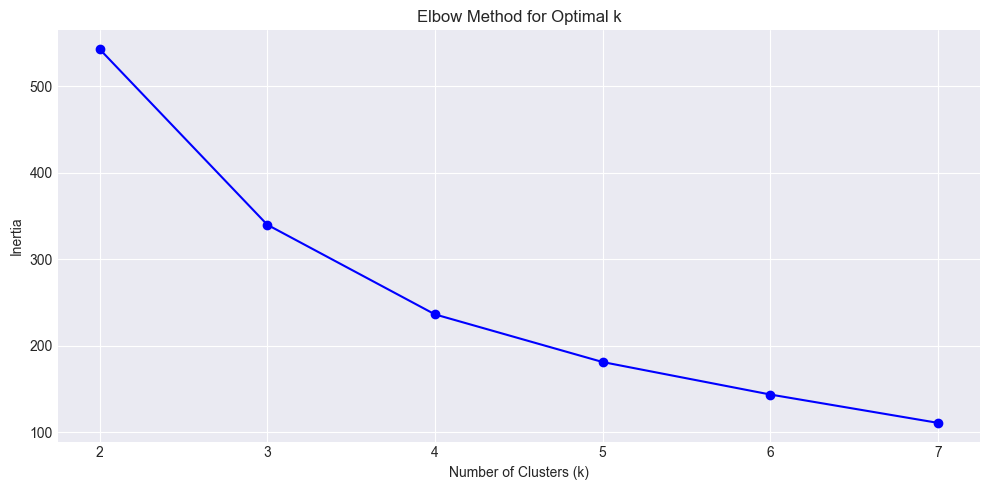


✓ Elbow plot saved

Using k=4 clusters

CLUSTER CHARACTERISTICS

Cluster 0 (n=22 events):
  Total rainfall: 9609.3 ± 4758.0
  Peak rainfall: 0.2005 ± 0.0640
  Duration: 32.9 ± 28.6 timesteps
  Peak 1D: 347.95 ± 0.00
  Peak 2D: 360.04 ± 0.02
  Sequence length: 110.8 ± 38.3

Cluster 1 (n=45 events):
  Total rainfall: 12594.6 ± 7711.2
  Peak rainfall: 0.1123 ± 0.0510
  Duration: 77.2 ± 50.4 timesteps
  Peak 1D: 46.87 ± 0.43
  Peak 2D: 55.23 ± 0.04
  Sequence length: 159.4 ± 53.9

Cluster 2 (n=46 events):
  Total rainfall: 19196.0 ± 4486.7
  Peak rainfall: 0.0809 ± 0.0342
  Duration: 190.6 ± 69.2 timesteps
  Peak 1D: 347.95 ± 0.00
  Peak 2D: 359.99 ± 0.02
  Sequence length: 288.5 ± 115.6

Cluster 3 (n=24 events):
  Total rainfall: 30533.6 ± 11097.7
  Peak rainfall: 0.1031 ± 0.0614
  Duration: 261.5 ± 51.3 timesteps
  Peak 1D: 47.22 ± 0.65
  Peak 2D: 55.22 ± 0.05
  Sequence length: 445.0 ± 0.0


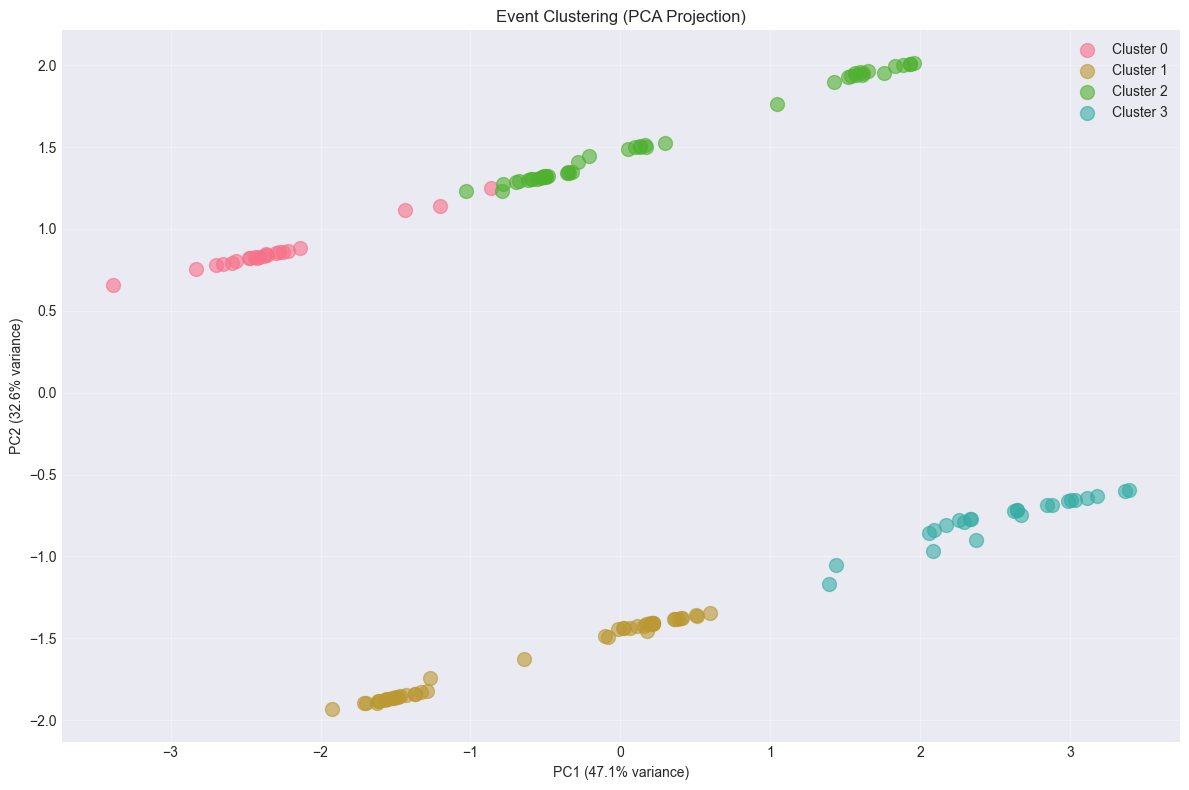


✓ Cluster visualization saved

CLUSTER DISTRIBUTION BY MODEL (%)
model_id     1     2
cluster             
0         32.4   0.0
1          0.0  65.2
2         67.6   0.0
3          0.0  34.8


In [21]:
# ============================================================================
# SECTION 2: EVENT CLUSTERING
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 2: EVENT CLUSTERING BY CHARACTERISTICS")
print("=" * 80)

# Select features for clustering
cluster_features = ['total_rainfall', 'peak_rainfall', 'rainfall_duration', 
                   'peak_1d', 'peak_2d', 'sequence_length']

X_cluster = events_all[cluster_features].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'clustering_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Elbow plot saved")

# Use k=4 (you can adjust based on elbow plot)
optimal_k = 4
print(f"\nUsing k={optimal_k} clusters")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
events_all['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
print("\n" + "=" * 80)
print("CLUSTER CHARACTERISTICS")
print("=" * 80)

for cluster_id in range(optimal_k):
    cluster_events = events_all[events_all['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_events)} events):")
    print(f"  Total rainfall: {cluster_events['total_rainfall'].mean():.1f} ± {cluster_events['total_rainfall'].std():.1f}")
    print(f"  Peak rainfall: {cluster_events['peak_rainfall'].mean():.4f} ± {cluster_events['peak_rainfall'].std():.4f}")
    print(f"  Duration: {cluster_events['rainfall_duration'].mean():.1f} ± {cluster_events['rainfall_duration'].std():.1f} timesteps")
    print(f"  Peak 1D: {cluster_events['peak_1d'].mean():.2f} ± {cluster_events['peak_1d'].std():.2f}")
    print(f"  Peak 2D: {cluster_events['peak_2d'].mean():.2f} ± {cluster_events['peak_2d'].std():.2f}")
    print(f"  Sequence length: {cluster_events['sequence_length'].mean():.1f} ± {cluster_events['sequence_length'].std():.1f}")

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for cluster_id in range(optimal_k):
    mask = events_all['cluster'] == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {cluster_id}', alpha=0.6, s=100)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Event Clustering (PCA Projection)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'event_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cluster visualization saved")

# Distribution of clusters by model
cluster_dist = pd.crosstab(events_all['cluster'], events_all['model_id'], normalize='columns') * 100

print("\n" + "=" * 80)
print("CLUSTER DISTRIBUTION BY MODEL (%)")
print("=" * 80)
print(cluster_dist.round(1))


SECTION 3: EXTREME EVENT IDENTIFICATION

Total Rainfall - Top 5 Events:
------------------------------------------------------------
  event_30 (Model 2, Cluster 3): 42130.20
  event_33 (Model 2, Cluster 3): 42130.20
  event_20 (Model 2, Cluster 3): 42130.20
  event_41 (Model 2, Cluster 3): 42087.21
  event_49 (Model 2, Cluster 3): 42044.22

Peak Rainfall Intensity - Top 5 Events:
------------------------------------------------------------
  event_74 (Model 1, Cluster 0): 0.38
  event_2 (Model 2, Cluster 1): 0.29
  event_78 (Model 1, Cluster 0): 0.29
  event_79 (Model 1, Cluster 0): 0.29
  event_47 (Model 2, Cluster 3): 0.27

Peak 1D Water Level - Top 5 Events:
------------------------------------------------------------
  event_1 (Model 1, Cluster 0): 347.95
  event_10 (Model 1, Cluster 2): 347.95
  event_11 (Model 1, Cluster 2): 347.95
  event_12 (Model 1, Cluster 2): 347.95
  event_13 (Model 1, Cluster 2): 347.95

Peak 2D Water Level - Top 5 Events:
-------------------------------

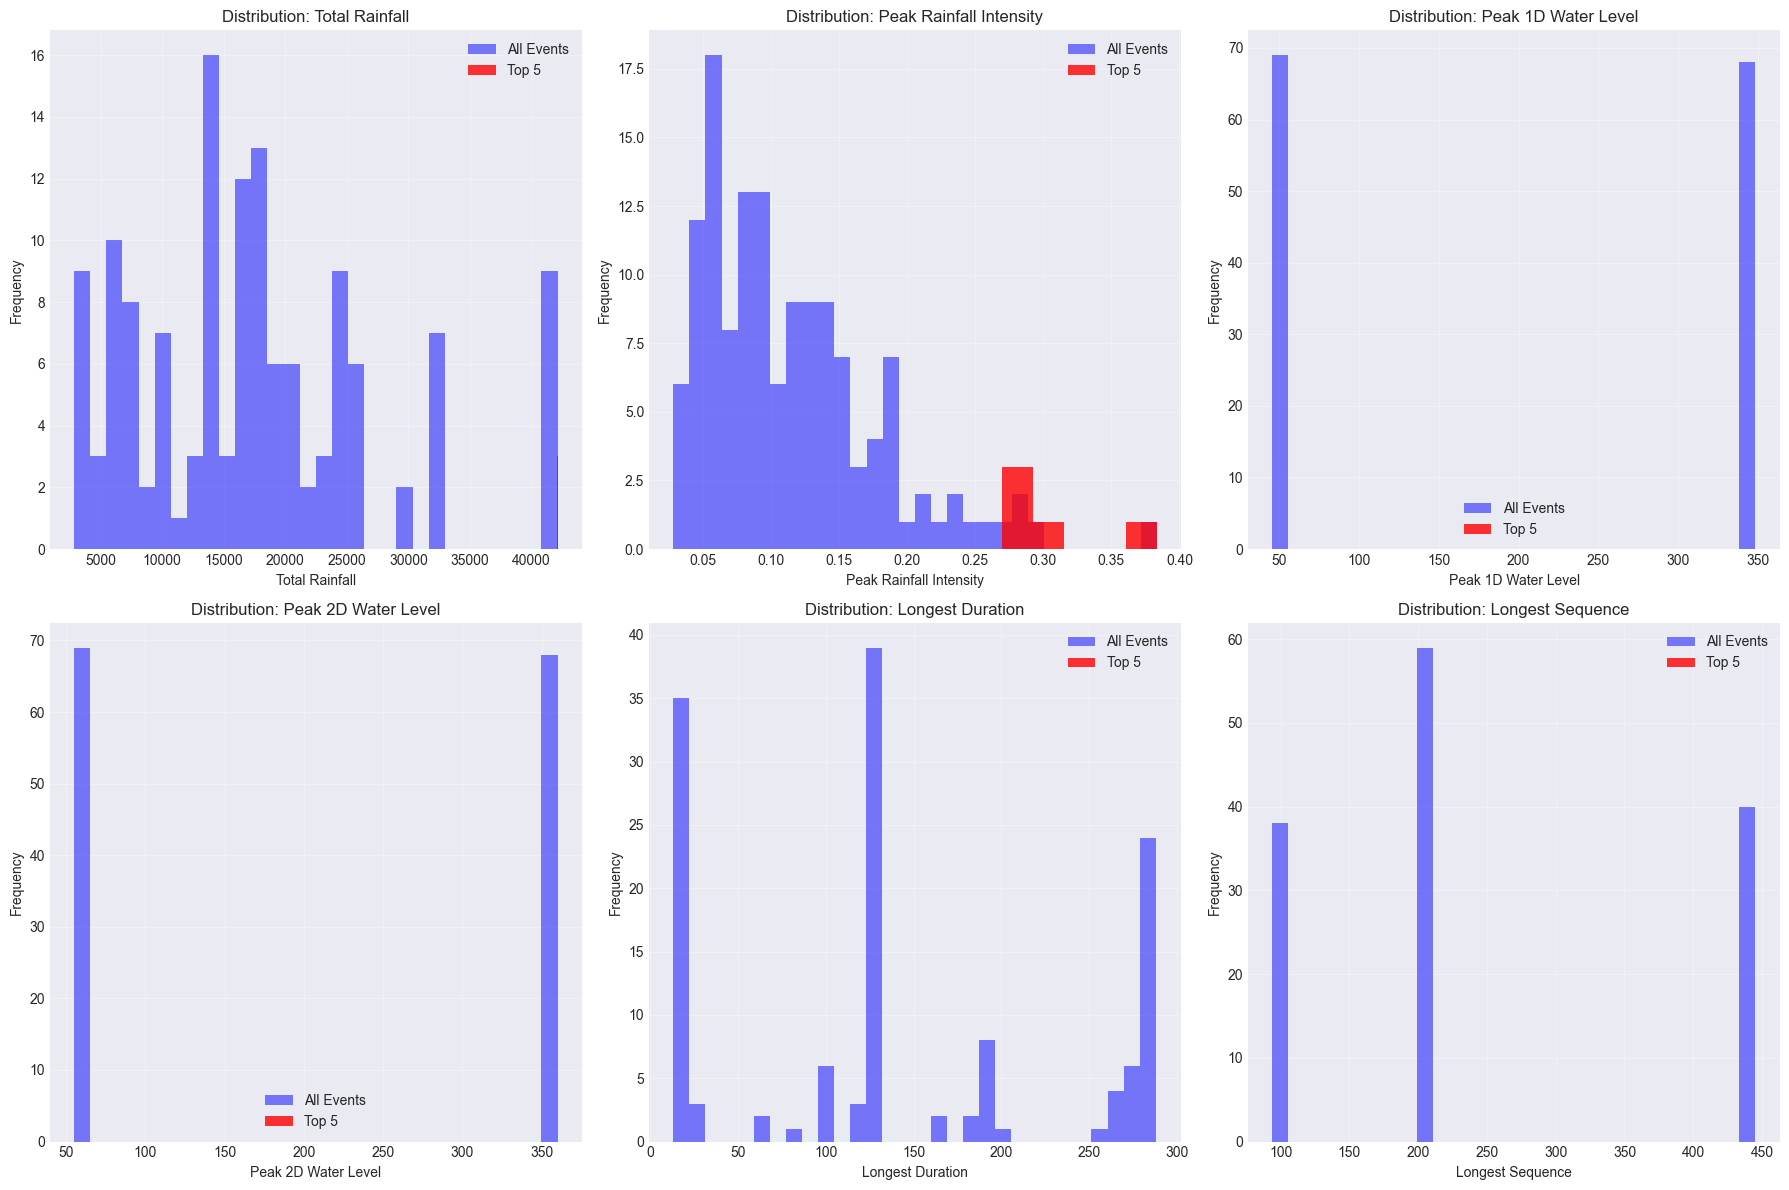


✓ Extreme event visualizations saved


In [22]:
# ============================================================================
# SECTION 3: EXTREME EVENT IDENTIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 3: EXTREME EVENT IDENTIFICATION")
print("=" * 80)

# Identify top 5 events by different criteria
extreme_criteria = {
    'Total Rainfall': 'total_rainfall',
    'Peak Rainfall Intensity': 'peak_rainfall',
    'Peak 1D Water Level': 'peak_1d',
    'Peak 2D Water Level': 'peak_2d',
    'Longest Duration': 'rainfall_duration',
    'Longest Sequence': 'sequence_length'
}

extreme_events_summary = []

for criterion_name, column in extreme_criteria.items():
    print(f"\n{criterion_name} - Top 5 Events:")
    print("-" * 60)
    
    top_5 = events_all.nlargest(5, column)[['model_id', 'event_id', column, 'cluster']]
    
    for idx, row in top_5.iterrows():
        print(f"  {row['event_id']} (Model {row['model_id']}, Cluster {row['cluster']}): {row[column]:.2f}")
        extreme_events_summary.append({
            'criterion': criterion_name,
            'model_id': row['model_id'],
            'event_id': row['event_id'],
            'value': row[column],
            'cluster': row['cluster']
        })

# Save extreme events
extreme_df = pd.DataFrame(extreme_events_summary)
extreme_df.to_csv(OUTPUT_DIR / 'extreme_events.csv', index=False)
print(f"\n✓ Extreme events saved to: {OUTPUT_DIR / 'extreme_events.csv'}")

# Visualize extreme events
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (criterion_name, column) in enumerate(extreme_criteria.items()):
    ax = axes[idx]
    
    # Histogram with extreme events highlighted
    ax.hist(events_all[column], bins=30, alpha=0.5, color='blue', label='All Events')
    
    top_5_values = events_all.nlargest(5, column)[column]
    ax.hist(top_5_values, bins=5, alpha=0.8, color='red', label='Top 5')
    
    ax.set_xlabel(criterion_name)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution: {criterion_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'extreme_events_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Extreme event visualizations saved")


SECTION 4: CROSS-EVENT VARIABILITY ANALYSIS

Computing variability for Model 1...
Computing variability for Model 2...

✓ Computed variability for 8230 nodes

NODE VARIABILITY SUMMARY (Coefficient of Variation)

Model 1:
  1D nodes:
    Mean CV: 0.0003
    Median CV: 0.0003
    Min CV: 0.0000
    Max CV: 0.0008
  2D nodes:
    Mean CV: 0.0002
    Median CV: 0.0001
    Min CV: 0.0000
    Max CV: 0.0026

Model 2:
  1D nodes:
    Mean CV: 0.0294
    Median CV: 0.0290
    Min CV: 0.0000
    Max CV: 0.0604
  2D nodes:
    Mean CV: 0.0055
    Median CV: 0.0027
    Min CV: 0.0002
    Max CV: 0.0631


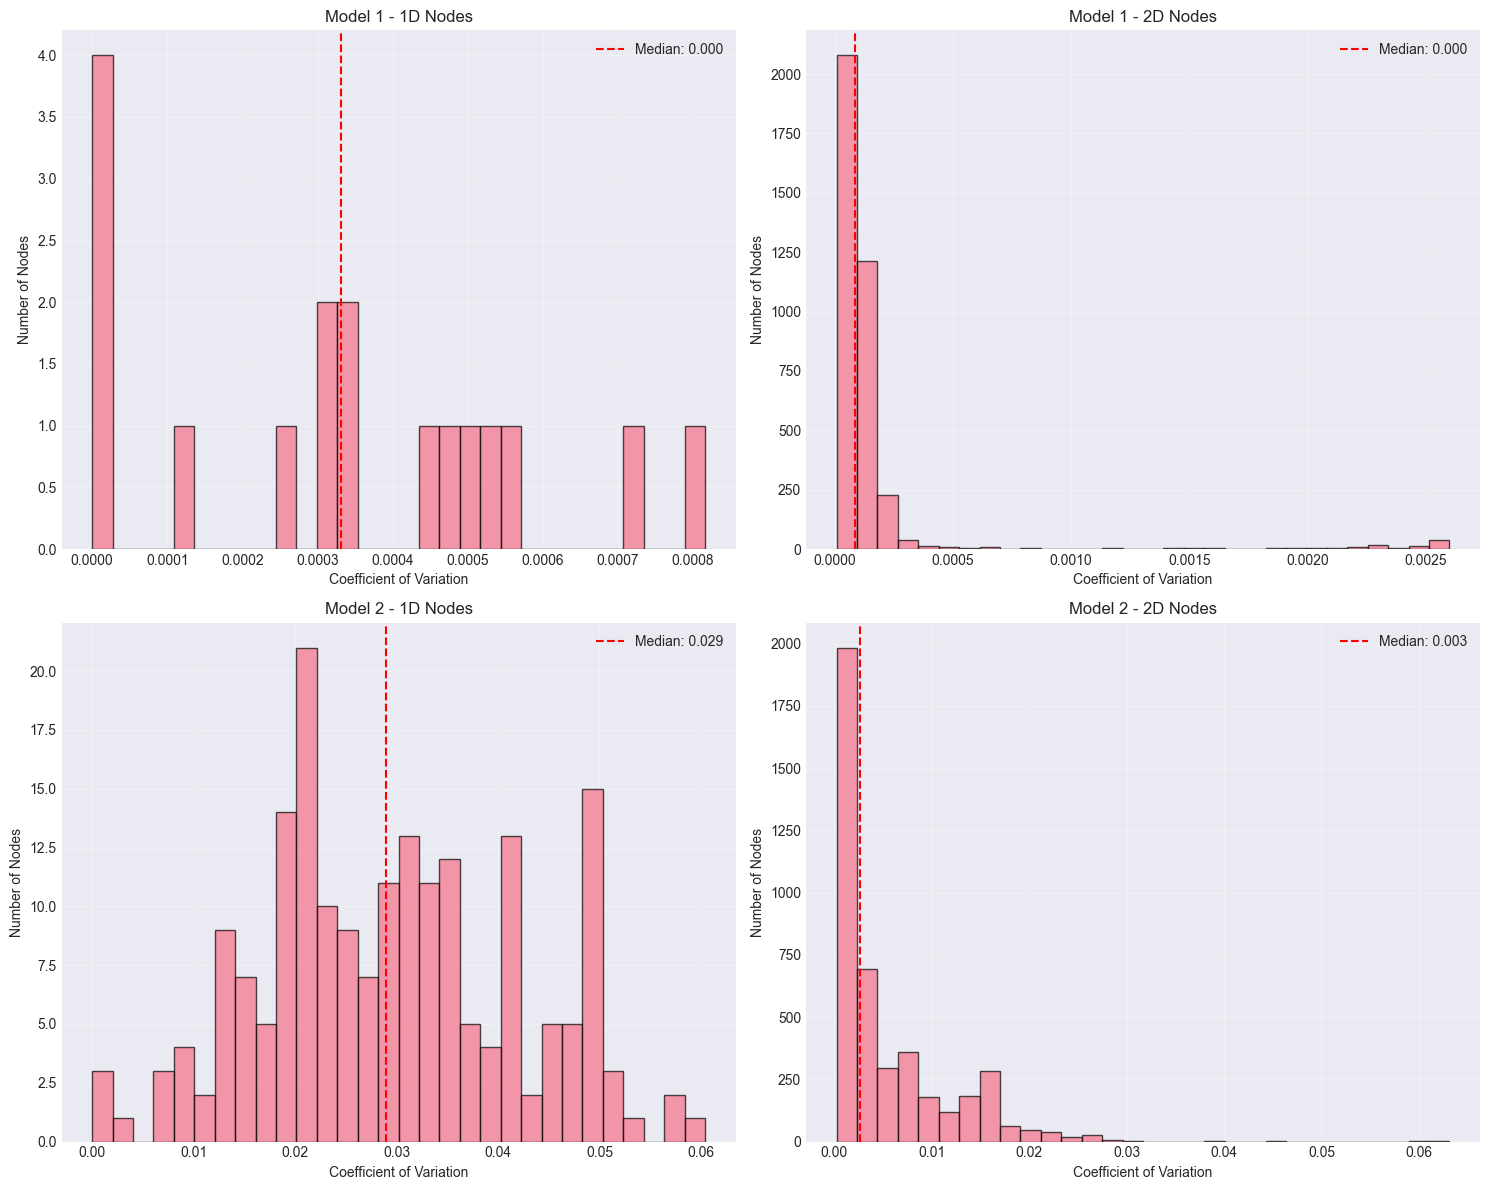


TOP 20 MOST VARIABLE NODES
 model_id node_type  node_idx       cv      mean      std
        2        2d      1464 0.063131 38.932565 2.457867
        2        2d      1465 0.060684 39.032616 2.368645
        2        1d       123 0.060401 37.124120 2.242348
        2        1d       193 0.058098 36.446600 2.117459
        2        1d       194 0.057310 36.375220 2.084678
        2        1d        20 0.052348 38.707107 2.026257
        2        1d        21 0.051200 38.226143 1.957181
        2        1d       103 0.051131 39.371551 2.013116
        2        1d        59 0.050928 39.014977 1.986970
        2        1d        58 0.050119 39.063771 1.957830
        2        1d       164 0.050103 37.345823 1.871144
        2        1d       165 0.050039 37.319800 1.867432
        2        1d       163 0.049810 37.361655 1.860982
        2        1d        19 0.049733 37.157243 1.847932
        2        1d       166 0.049361 37.386424 1.845436
        2        1d         3 0.049254 36.82

In [23]:
# ============================================================================
# SECTION 4: CROSS-EVENT VARIABILITY ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 4: CROSS-EVENT VARIABILITY ANALYSIS")
print("=" * 80)

def compute_node_variability(model_dir, model_id, node_type):
    """Compute coefficient of variation per node across all events"""
    
    event_dirs = sorted([d for d in model_dir.iterdir() 
                        if d.is_dir() and d.name.startswith('event_')])
    
    # Collect water levels for each node across all events
    node_values = {}
    
    for event_dir in event_dirs:
        try:
            if node_type == '1d':
                dyn = pd.read_csv(event_dir / "1d_nodes_dynamic_all.csv")
            else:
                dyn = pd.read_csv(event_dir / "2d_nodes_dynamic_all.csv")
            
            wl = dyn.pivot(index='timestep', columns='node_idx', values='water_level')
            
            # Get mean water level per node for this event
            for node_idx in wl.columns:
                if node_idx not in node_values:
                    node_values[node_idx] = []
                node_values[node_idx].append(wl[node_idx].mean())
        
        except Exception as e:
            continue
    
    # Compute coefficient of variation
    cv_results = []
    for node_idx, values in node_values.items():
        if len(values) > 1:
            mean_val = np.mean(values)
            std_val = np.std(values)
            cv = std_val / mean_val if mean_val != 0 else 0
            
            cv_results.append({
                'model_id': model_id,
                'node_type': node_type,
                'node_idx': node_idx,
                'mean': mean_val,
                'std': std_val,
                'cv': cv,
                'n_events': len(values)
            })
    
    return pd.DataFrame(cv_results)

# Compute for both models and node types
print("\nComputing variability for Model 1...")
cv_m1_1d = compute_node_variability(MODEL_1_DIR, 1, '1d')
cv_m1_2d = compute_node_variability(MODEL_1_DIR, 1, '2d')

print("Computing variability for Model 2...")
cv_m2_1d = compute_node_variability(MODEL_2_DIR, 2, '1d')
cv_m2_2d = compute_node_variability(MODEL_2_DIR, 2, '2d')

# Combine
cv_all = pd.concat([cv_m1_1d, cv_m1_2d, cv_m2_1d, cv_m2_2d], ignore_index=True)

print(f"\n✓ Computed variability for {len(cv_all)} nodes")

# Save
cv_all.to_csv(OUTPUT_DIR / 'node_variability.csv', index=False)

# Summary statistics
print("\n" + "=" * 80)
print("NODE VARIABILITY SUMMARY (Coefficient of Variation)")
print("=" * 80)

for model_id in [1, 2]:
    print(f"\nModel {model_id}:")
    for node_type in ['1d', '2d']:
        subset = cv_all[(cv_all['model_id'] == model_id) & (cv_all['node_type'] == node_type)]
        if len(subset) > 0:
            print(f"  {node_type.upper()} nodes:")
            print(f"    Mean CV: {subset['cv'].mean():.4f}")
            print(f"    Median CV: {subset['cv'].median():.4f}")
            print(f"    Min CV: {subset['cv'].min():.4f}")
            print(f"    Max CV: {subset['cv'].max():.4f}")

# Visualize most and least variable nodes
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, model_id in enumerate([1, 2]):
    for jdx, node_type in enumerate(['1d', '2d']):
        ax = axes[idx, jdx]
        
        subset = cv_all[(cv_all['model_id'] == model_id) & (cv_all['node_type'] == node_type)]
        
        if len(subset) > 0:
            # Histogram of CV
            ax.hist(subset['cv'], bins=30, alpha=0.7, edgecolor='black')
            median_cv = subset['cv'].median()
            ax.axvline(median_cv, color='red', linestyle='--', 
                      label=f'Median: {median_cv:.3f}')  # Fixed line
            ax.set_xlabel('Coefficient of Variation')
            ax.set_ylabel('Number of Nodes')
            ax.set_title(f'Model {model_id} - {node_type.upper()} Nodes')
            ax.legend()
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'node_variability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify most variable nodes (top 20)
print("\n" + "=" * 80)
print("TOP 20 MOST VARIABLE NODES")
print("=" * 80)

top_variable = cv_all.nlargest(20, 'cv')[['model_id', 'node_type', 'node_idx', 'cv', 'mean', 'std']]
print(top_variable.to_string(index=False))

# Identify most stable nodes (bottom 20)
print("\n" + "=" * 80)
print("TOP 20 MOST STABLE NODES")
print("=" * 80)

most_stable = cv_all.nsmallest(20, 'cv')[['model_id', 'node_type', 'node_idx', 'cv', 'mean', 'std']]
print(most_stable.to_string(index=False))

print("\n✓ Variability analysis complete")


SECTION 5: MODEL 1 vs MODEL 2 COMPARISON

MODEL COMPARISON SUMMARY
                  Metric      Model 1      Model 2 Difference (%)
                1D Nodes    17.000000   198.000000       +1064.7%
                2D Nodes  3716.000000  4299.000000         +15.7%
  1D Elevation Range (m)    63.780000    29.710000         -53.4%
  2D Elevation Range (m)    66.406250    25.906250         -61.0%
     Num Training Events    68.000000    69.000000          +1.5%
Mean Total Rainfall (mm) 16094.406174 18834.292615         +17.0%
        Mean Peak 1D (m)   347.952450    46.991629         -86.5%
        Mean Peak 2D (m)   360.005095    55.225961         -84.7%
    Mean Sequence Length   230.985294   258.739130         +12.0%


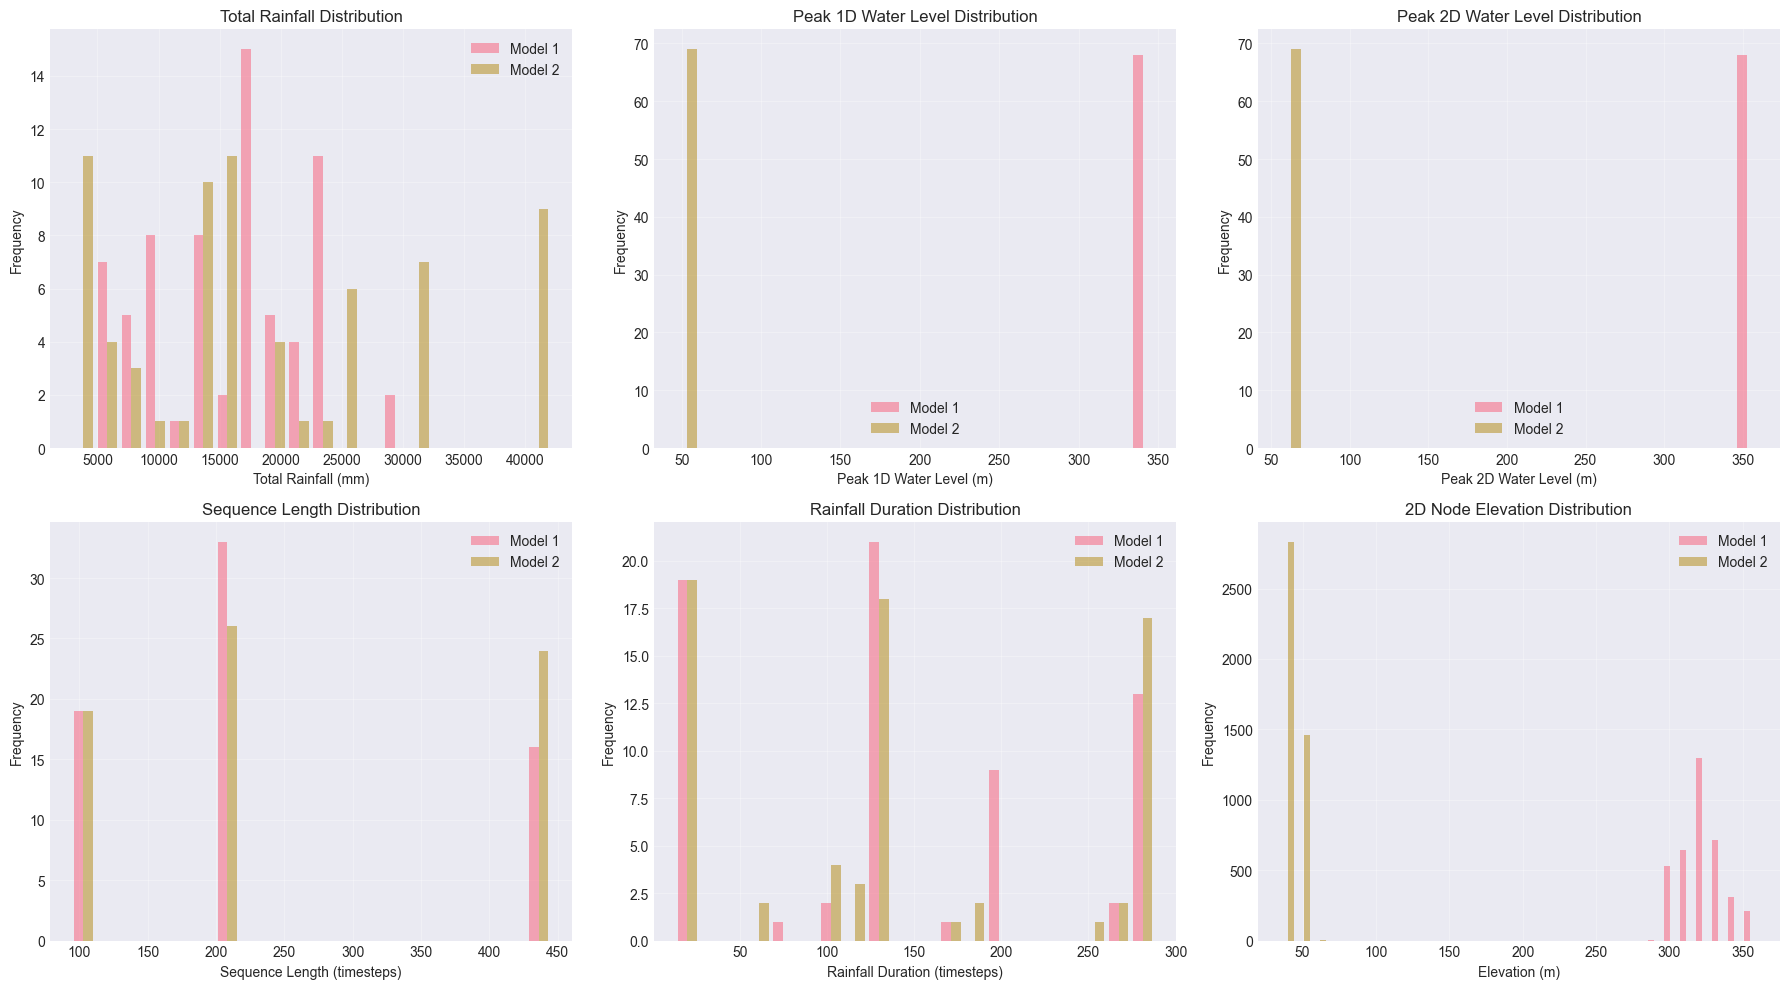


✓ Model comparison visualizations saved


In [17]:
# ============================================================================
# SECTION 5: MODEL 1 vs MODEL 2 COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 5: MODEL 1 vs MODEL 2 COMPARISON")
print("=" * 80)

# Load static features to compare network properties
static_1d_m1 = pd.read_csv(MODEL_1_DIR / "1d_nodes_static.csv")
static_2d_m1 = pd.read_csv(MODEL_1_DIR / "2d_nodes_static.csv")
static_1d_m2 = pd.read_csv(MODEL_2_DIR / "1d_nodes_static.csv")
static_2d_m2 = pd.read_csv(MODEL_2_DIR / "2d_nodes_static.csv")

# Network size comparison
comparison = {
    'Metric': [],
    'Model 1': [],
    'Model 2': [],
    'Difference (%)': []
}

def add_comparison(metric, val1, val2):
    comparison['Metric'].append(metric)
    comparison['Model 1'].append(val1)
    comparison['Model 2'].append(val2)
    diff_pct = ((val2 - val1) / val1 * 100) if val1 != 0 else 0
    comparison['Difference (%)'].append(f"{diff_pct:+.1f}%")

# Network sizes
add_comparison('1D Nodes', len(static_1d_m1), len(static_1d_m2))
add_comparison('2D Nodes', len(static_2d_m1), len(static_2d_m2))

# Elevation ranges
add_comparison('1D Elevation Range (m)', 
               static_1d_m1['surface_elevation'].max() - static_1d_m1['surface_elevation'].min(),
               static_1d_m2['surface_elevation'].max() - static_1d_m2['surface_elevation'].min())

add_comparison('2D Elevation Range (m)',
               static_2d_m1['elevation'].max() - static_2d_m1['elevation'].min(),
               static_2d_m2['elevation'].max() - static_2d_m2['elevation'].min())

# Event characteristics
add_comparison('Num Training Events', len(events_m1), len(events_m2))
add_comparison('Mean Total Rainfall (mm)', 
               events_m1['total_rainfall'].mean(),
               events_m2['total_rainfall'].mean())
add_comparison('Mean Peak 1D (m)',
               events_m1['peak_1d'].mean(),
               events_m2['peak_1d'].mean())
add_comparison('Mean Peak 2D (m)',
               events_m1['peak_2d'].mean(),
               events_m2['peak_2d'].mean())
add_comparison('Mean Sequence Length',
               events_m1['sequence_length'].mean(),
               events_m2['sequence_length'].mean())

comparison_df = pd.DataFrame(comparison)

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)

# Visualize key differences
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Total rainfall comparison
axes[0, 0].hist([events_m1['total_rainfall'], events_m2['total_rainfall']], 
                bins=20, label=['Model 1', 'Model 2'], alpha=0.6)
axes[0, 0].set_xlabel('Total Rainfall (mm)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Total Rainfall Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Peak 1D comparison
axes[0, 1].hist([events_m1['peak_1d'], events_m2['peak_1d']], 
                bins=20, label=['Model 1', 'Model 2'], alpha=0.6)
axes[0, 1].set_xlabel('Peak 1D Water Level (m)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Peak 1D Water Level Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Peak 2D comparison
axes[0, 2].hist([events_m1['peak_2d'], events_m2['peak_2d']], 
                bins=20, label=['Model 1', 'Model 2'], alpha=0.6)
axes[0, 2].set_xlabel('Peak 2D Water Level (m)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Peak 2D Water Level Distribution')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Sequence length comparison
axes[1, 0].hist([events_m1['sequence_length'], events_m2['sequence_length']], 
                bins=20, label=['Model 1', 'Model 2'], alpha=0.6)
axes[1, 0].set_xlabel('Sequence Length (timesteps)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Sequence Length Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Rainfall duration comparison
axes[1, 1].hist([events_m1['rainfall_duration'], events_m2['rainfall_duration']], 
                bins=20, label=['Model 1', 'Model 2'], alpha=0.6)
axes[1, 1].set_xlabel('Rainfall Duration (timesteps)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Rainfall Duration Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Elevation comparison (2D nodes)
axes[1, 2].hist([static_2d_m1['elevation'], static_2d_m2['elevation']], 
                bins=30, label=['Model 1', 'Model 2'], alpha=0.6)
axes[1, 2].set_xlabel('Elevation (m)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('2D Node Elevation Distribution')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Model comparison visualizations saved")

In [18]:
# ============================================================================
# SECTION 6: BASELINE MODEL PERFORMANCE
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 6: BASELINE MODEL PERFORMANCE (PERSISTENCE)")
print("=" * 80)

def calculate_persistence_baseline(model_dir, model_id, norm_1d, norm_2d):
    """
    Calculate RMSE for a persistence model (predicting t+1 = t).
    Also estimates standardized RMSE by calculating local standard deviation.
    """
    event_dirs = sorted([d for d in model_dir.iterdir() 
                        if d.is_dir() and d.name.startswith('event_')])
    
    rmse_1d_list = []
    rmse_2d_list = []
    
    print(f"\nCalculating baseline for Model {model_id}...")
    
    count = 0
    for event_dir in event_dirs:
        try:
            # Load dynamic data
            dyn_1d = pd.read_csv(event_dir / "1d_nodes_dynamic_all.csv")
            dyn_2d = pd.read_csv(event_dir / "2d_nodes_dynamic_all.csv")
            
            # Pivot
            wl_1d = dyn_1d.pivot(index='timestep', columns='node_idx', values='water_level')
            wl_2d = dyn_2d.pivot(index='timestep', columns='node_idx', values='water_level')
            
            # Persistence: Pred(t) = Act(t-1)
            # Alignment: Target is wl[1:], Pred is wl[:-1]
            target_1d = wl_1d.iloc[1:].values
            pred_1d = wl_1d.iloc[:-1].values
            
            target_2d = wl_2d.iloc[1:].values
            pred_2d = wl_2d.iloc[:-1].values
            
            # Calculate MSE
            mse_1d = np.mean((target_1d - pred_1d) ** 2)
            mse_2d = np.mean((target_2d - pred_2d) ** 2)
            
            rmse_1d_list.append(np.sqrt(mse_1d))
            rmse_2d_list.append(np.sqrt(mse_2d))
            
            count += 1
            if count % 20 == 0:
                print(f"  Processed {count}/{len(event_dirs)} events...")
                
        except Exception as e:
            continue
            
    # Calculate statistics
    rmse_1d_mean = np.mean(rmse_1d_list)
    rmse_1d_std = np.std(rmse_1d_list)
    rmse_2d_mean = np.mean(rmse_2d_list)
    rmse_2d_std = np.std(rmse_2d_list)
    
    return {
        'rmse_1d_mean': rmse_1d_mean,
        'rmse_1d_std': rmse_1d_std,
        'std_rmse_1d': rmse_1d_mean / norm_1d if norm_1d > 0 else 0,
        'rmse_2d_mean': rmse_2d_mean,
        'rmse_2d_std': rmse_2d_std,
        'std_rmse_2d': rmse_2d_mean / norm_2d if norm_2d > 0 else 0
    }

# Normalization factors (mean std across events from Section 1)
normalization_1d_m1 = events_m1['std_1d'].mean()
normalization_2d_m1 = events_m1['std_2d'].mean()
normalization_1d_m2 = events_m2['std_1d'].mean()
normalization_2d_m2 = events_m2['std_2d'].mean()

baseline_m1 = calculate_persistence_baseline(MODEL_1_DIR, 1, normalization_1d_m1, normalization_2d_m1)
baseline_m2 = calculate_persistence_baseline(MODEL_2_DIR, 2, normalization_1d_m2, normalization_2d_m2)

# Print results
print("\nModel 1:")
print(f"  1D RMSE: {baseline_m1['rmse_1d_mean']:.4f} ± {baseline_m1['rmse_1d_std']:.4f} m")
print(f"  1D Standardized RMSE: {baseline_m1['std_rmse_1d']:.4f}")
print(f"  2D RMSE: {baseline_m1['rmse_2d_mean']:.4f} ± {baseline_m1['rmse_2d_std']:.4f} m")
print(f"  2D Standardized RMSE: {baseline_m1['std_rmse_2d']:.4f}")
print(f"  Average Standardized RMSE: {(baseline_m1['std_rmse_1d'] + baseline_m1['std_rmse_2d']) / 2:.4f}")

print("\nModel 2:")
print(f"  1D RMSE: {baseline_m2['rmse_1d_mean']:.4f} ± {baseline_m2['rmse_1d_std']:.4f} m")
print(f"  1D Standardized RMSE: {baseline_m2['std_rmse_1d']:.4f}")
print(f"  2D RMSE: {baseline_m2['rmse_2d_mean']:.4f} ± {baseline_m2['rmse_2d_std']:.4f} m")
print(f"  2D Standardized RMSE: {baseline_m2['std_rmse_2d']:.4f}")
print(f"  Average Standardized RMSE: {(baseline_m2['std_rmse_1d'] + baseline_m2['std_rmse_2d']) / 2:.4f}")

# Save baseline results
baseline_df = pd.DataFrame([
    {'model_id': 1, **baseline_m1},
    {'model_id': 2, **baseline_m2}
])
baseline_df.to_csv(OUTPUT_DIR / 'baseline_performance.csv', index=False)
print(f"\n✓ Baseline performance saved to: {OUTPUT_DIR / 'baseline_performance.csv'}")


SECTION 6: BASELINE MODEL PERFORMANCE (PERSISTENCE)

Calculating baseline for Model 1...
  Processed 20/68 events...
  Processed 40/68 events...
  Processed 60/68 events...

Calculating baseline for Model 2...
  Processed 20/69 events...
  Processed 40/69 events...
  Processed 60/69 events...

Model 1:
  1D RMSE: 0.0830 ± 0.0766 m
  1D Standardized RMSE: 0.2148
  2D RMSE: 0.0157 ± 0.0065 m
  2D Standardized RMSE: 0.1141
  Average Standardized RMSE: 0.1645

Model 2:
  1D RMSE: 0.1001 ± 0.0357 m
  1D Standardized RMSE: 0.0666
  2D RMSE: 0.0155 ± 0.0046 m
  2D Standardized RMSE: 0.0557
  Average Standardized RMSE: 0.0612

✓ Baseline performance saved to: analysis_output\part5_event_analysis\baseline_performance.csv


In [20]:
# ============================================================================
# SECTION 7: MODELING RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 80)
print("SECTION 7: GENERATING MODELING RECOMMENDATIONS")
print("=" * 80)

recommendations = f"""
================================================================================
URBAN FLOOD FORECASTING - FINAL MODELING RECOMMENDATIONS
================================================================================

EXECUTIVE SUMMARY
-----------------
Based on comprehensive analysis of {len(events_all)} events across 2 models, 
here are the key insights and recommended modeling approaches.

1. DATA CHARACTERISTICS
-----------------------
Network Sizes:
  • Model 1: {len(static_1d_m1)} 1D nodes, {len(static_2d_m1)} 2D nodes
  • Model 2: {len(static_1d_m2)} 1D nodes, {len(static_2d_m2)} 2D nodes
  • Extreme imbalance: ~220x more 2D nodes than 1D nodes
  
Event Diversity:
  • Identified {optimal_k} distinct event clusters
  • Rainfall range: {events_all['total_rainfall'].min():.1f} - {events_all['total_rainfall'].max():.1f} mm
  • Sequence lengths: {events_all['sequence_length'].min():.0f} - {events_all['sequence_length'].max():.0f} timesteps
  • High variability in response patterns across events

Cross-Event Variability:
  • Model 1 - 1D nodes CV: {cv_m1_1d['cv'].mean():.4f}
  • Model 1 - 2D nodes CV: {cv_m1_2d['cv'].mean():.4f}
  • Model 2 - 1D nodes CV: {cv_m2_1d['cv'].mean():.4f}
  • Model 2 - 2D nodes CV: {cv_m2_2d['cv'].mean():.4f}

2. BASELINE PERFORMANCE
-----------------------
Persistence Model (predict t+1 = t):
  
  Model 1:
    • 1D Standardized RMSE: {baseline_m1['std_rmse_1d']:.4f}
    • 2D Standardized RMSE: {baseline_m1['std_rmse_2d']:.4f}
    • Average: {(baseline_m1['std_rmse_1d'] + baseline_m1['std_rmse_2d']) / 2:.4f}
  
  Model 2:
    • 1D Standardized RMSE: {baseline_m2['std_rmse_1d']:.4f}
    • 2D Standardized RMSE: {baseline_m2['std_rmse_2d']:.4f}
    • Average: {(baseline_m2['std_rmse_1d'] + baseline_m2['std_rmse_2d']) / 2:.4f}

Your model MUST significantly beat these baselines!

3. CRITICAL MODELING DECISIONS
-------------------------------

A. SEPARATE vs UNIFIED MODELS
   RECOMMENDATION: Use SEPARATE models for 1D and 2D
   
   Rationale:
   • 1D and 2D have equal contribution to final score
   • 1D has 220x fewer nodes → needs MORE model capacity
   • Different physics (pipe flow vs shallow water)
   • Different feature spaces and scales
   
   Architecture:
   • 1D Model: High-capacity GNN + LSTM (e.g., 256-512 hidden dims)
   • 2D Model: Efficient mesh processor (U-Net, GCN, or ConvLSTM)
   • Share rainfall and coupling information between models

B. HANDLING NODE TYPE IMBALANCE
   CRITICAL: The 1D nodes contribute 50% to final score but are <0.5% of nodes!
   
   Strategies:
   1. Weighted loss: 220x weight for 1D node errors
   2. Separate optimizers with different learning rates
   3. Oversampling: Augment 1D training data
   4. Ensemble: Combine specialist models

C. TEMPORAL PREDICTION STRATEGY
   Max prediction horizon: {int(events_all['sequence_length'].max())} timesteps
   
   Recommendations:
   1. Use autoregressive approach with teacher forcing schedule
   2. Add Gaussian noise during training to reduce error accumulation
   3. Multi-step loss: Σ L(t+1) + L(t+2) + ... + L(t+k)
   4. Consider residual predictions: Δwater_level instead of absolute
   
   Teacher forcing schedule:
   • Epochs 0-20: 90% teacher forcing
   • Epochs 20-40: 70% teacher forcing
   • Epochs 40-60: 50% teacher forcing
   • Epochs 60+: 30% teacher forcing

D. FEATURE ENGINEERING PRIORITIES
   From correlation analysis (Part 4), prioritize:
   
   Temporal features:
   • Lagged water levels (t-1, t-2, t-3) [high autocorrelation]
   • Cumulative rainfall up to timestep
   • Rainfall rate (difference)
   • Rolling statistics (5-10 timestep windows)
   
   Spatial features:
   • Distance to nearest 1D node (for 2D)
   • Upstream/downstream aggregations
   • Elevation gradients
   • Flow accumulation zones
   
   Physics-informed:
   • Storage capacity: (surface_elevation - invert_elevation) * area
   • Hydraulic gradients
   • Volume balance proxies

E. CROSS-VALIDATION STRATEGY
   DO NOT use random train/test splits!
   
   Recommended approach:
   1. Stratified by event clusters (ensure all {optimal_k} clusters in validation)
   2. Leave-events-out cross-validation (5-fold)
   3. Temporal split: Use last 20% of events as validation
   
   Validation sets should contain:
   • At least one event from each cluster
   • Events covering full rainfall intensity range
   • Both short and long sequences

F. MODEL GENERALIZATION (Model 1 → Model 2)
   Transferability assessment:
   • Models have {(abs(len(static_1d_m1) - len(static_1d_m2)) / len(static_1d_m1) * 100):.1f}% difference in 1D network size
   • Models have {(abs(len(static_2d_m1) - len(static_2d_m2)) / len(static_2d_m1) * 100):.1f}% difference in 2D network size
   
   Strategies:
   1. Train separate models per catchment (safer)
   2. OR use domain adaptation techniques
   3. OR meta-learning across catchments
   
   RECOMMENDATION: Train separately unless you have strong transfer learning expertise

4. RECOMMENDED ARCHITECTURE
---------------------------

Option A: Separate GNN-LSTM Models (RECOMMENDED)
```python
# 1D Model (High Capacity)
class Model1D:
    - Node embedding: 128 dims
    - GNN layers: 3x GAT (8 heads, 256 hidden)
    - 1D-2D coupling layer
    - LSTM: 3 layers, 512 hidden
    - Decoder: MLP [512 → 256 → 128 → 1]
    - Total params: ~5-10M

# 2D Model (Efficient)
class Model2D:
    - Node embedding: 64 dims
    - U-Net or GCN: 4 layers, 128 hidden
    - Coupling from 1D predictions
    - ConvLSTM or Transformer: 256 hidden
    - Decoder: MLP [256 → 128 → 1]
    - Total params: ~2-5M
```

Option B: Unified Heterogeneous GNN
```python
# Single model with node-type-specific processing
class HeteroHydraulicGNN:
    - Separate encoders for 1D (256 dims) and 2D (64 dims)
    - Heterogeneous message passing
    - Node-type-specific decoders
    - Shared temporal backbone (LSTM)
```

5. TRAINING CONFIGURATION
-------------------------

Loss Function:
```python
def standardized_rmse_loss(pred, target, std_dict, node_types):
    # Separate by node type
    loss_1d = rmse(pred[node_types==1], target[node_types==1]) / std_dict['1d']
    loss_2d = rmse(pred[node_types==2], target[node_types==2]) / std_dict['2d']
    
    # Equal weighting (critical!)
    return (loss_1d + loss_2d) / 2
```

Optimizer:
- AdamW with weight decay 1e-4
- Learning rate: 1e-3 for 1D, 5e-4 for 2D
- Cosine annealing schedule
- Gradient clipping: max_norm=1.0

Regularization:
- Dropout: 0.3-0.4
- Layer normalization
- Early stopping: patience=15 epochs

Training:
- Batch size: 32 sequences (or full events)
- Epochs: 100-200
- Validation every 5 epochs

6. EXPECTED PERFORMANCE TARGETS
--------------------------------

Conservative Targets (Beat to be competitive):
- Model 1: Standardized RMSE < {(baseline_m1['std_rmse_1d'] + baseline_m1['std_rmse_2d']) / 2 * 0.5:.4f}
- Model 2: Standardized RMSE < {(baseline_m2['std_rmse_1d'] + baseline_m2['std_rmse_2d']) / 2 * 0.5:.4f}
- Overall: < {((baseline_m1['std_rmse_1d'] + baseline_m1['std_rmse_2d']) / 2 + (baseline_m2['std_rmse_1d'] + baseline_m2['std_rmse_2d']) / 2) / 2 * 0.5:.4f}

Competitive Targets (Top 10):
- Model 1: Standardized RMSE < {(baseline_m1['std_rmse_1d'] + baseline_m1['std_rmse_2d']) / 2 * 0.3:.4f}
- Model 2: Standardized RMSE < {(baseline_m2['std_rmse_1d'] + baseline_m2['std_rmse_2d']) / 2 * 0.3:.4f}
- Overall: < {((baseline_m1['std_rmse_1d'] + baseline_m1['std_rmse_2d']) / 2 + (baseline_m2['std_rmse_1d'] + baseline_m2['std_rmse_2d']) / 2) / 2 * 0.3:.4f}

Winning Targets (Top 3):
- Overall: < {((baseline_m1['std_rmse_1d'] + baseline_m1['std_rmse_2d']) / 2 + (baseline_m2['std_rmse_1d'] + baseline_m2['std_rmse_2d']) / 2) / 2 * 0.15:.4f}

7. IMPLEMENTATION ROADMAP
-------------------------

Week 1: Foundation
□ Implement data loaders with proper batching
□ Build basic LSTM baseline (beat persistence)
□ Setup standardized RMSE metric exactly as competition
□ Implement cross-validation framework

Week 2: Core Models
□ Implement GNN for 1D network
□ Implement spatial processor for 2D mesh (U-Net or GCN)
□ Add 1D-2D coupling features
□ Integrate temporal models (LSTM/Transformer)

Week 3: Optimization
□ Implement autoregressive forecasting with teacher forcing
□ Add multi-step loss
□ Hyperparameter tuning
□ Error accumulation mitigation

Week 4: Ensemble & Finalization
□ Train multiple model variants
□ Build ensemble
□ Generate final predictions
□ Validate submission format

8. RISK MITIGATION
------------------

Major Risks:
1. Overfitting to 1D (high capacity, few nodes)
   → Solution: Strong regularization, data augmentation
   
2. Error accumulation in long sequences
   → Solution: Multi-step loss, noise injection, residual predictions
   
3. Public/private leaderboard gap
   → Solution: Robust CV, don't overfit to public LB
   
4. Model 1 → Model 2 generalization
   → Solution: Train separate models, validate on both

9. KEY SUCCESS FACTORS
----------------------

✓ Equal performance on 1D and 2D (they contribute equally!)
✓ Robust autoregressive forecasting (minimize error accumulation)
✓ Strong generalization across event types
✓ Proper handling of standardized RMSE metric
✓ Cross-model generalization (Model 1 ↔ Model 2)

10. NEXT STEPS
--------------

Immediate actions:
1. Review this analysis thoroughly
2. Setup development environment with PyTorch Geometric or DGL
3. Implement data pipeline (start with data_loader.py)
4. Build simple LSTM baseline (target: beat persistence by 50%)
5. Incrementally add GNN components

Good luck! You have all the insights needed to build a winning solution.

================================================================================
ANALYSIS COMPLETE - {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================
"""

print(recommendations)

# Save recommendations
with open(OUTPUT_DIR / 'modeling_recommendations.txt', 'w', encoding='utf-8') as f:
    f.write(recommendations)

print(f"\n✓ Recommendations saved to: {OUTPUT_DIR / 'modeling_recommendations.txt'}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("PART 5 COMPLETE - ALL OUTPUTS GENERATED")
print("=" * 80)

print("\n📁 Generated Files:")
print(f"  • {OUTPUT_DIR / 'event_characteristics.csv'}")
print(f"  • {OUTPUT_DIR / 'extreme_events.csv'}")
print(f"  • {OUTPUT_DIR / 'node_variability.csv'}")
print(f"  • {OUTPUT_DIR / 'model_comparison.csv'}")
print(f"  • {OUTPUT_DIR / 'baseline_performance.csv'}")
print(f"  • {OUTPUT_DIR / 'modeling_recommendations.txt'}")

print("\n📊 Generated Figures:")
print(f"  • {FIGURES_DIR / 'clustering_elbow_method.png'}")
print(f"  • {FIGURES_DIR / 'event_clusters_pca.png'}")
print(f"  • {FIGURES_DIR / 'extreme_events_distributions.png'}")
print(f"  • {FIGURES_DIR / 'node_variability_distributions.png'}")
print(f"  • {FIGURES_DIR / 'model_comparison_distributions.png'}")

print("\n" + "=" * 80)
print("✓ ANALYSIS PHASE COMPLETE!")
print("=" * 80)
print("\n🎯 Next Step: Read modeling_recommendations.txt and start building your model!")


SECTION 7: GENERATING MODELING RECOMMENDATIONS

URBAN FLOOD FORECASTING - FINAL MODELING RECOMMENDATIONS

EXECUTIVE SUMMARY
-----------------
Based on comprehensive analysis of 137 events across 2 models, 
here are the key insights and recommended modeling approaches.

1. DATA CHARACTERISTICS
-----------------------
Network Sizes:
  • Model 1: 17 1D nodes, 3716 2D nodes
  • Model 2: 198 1D nodes, 4299 2D nodes
  • Extreme imbalance: ~220x more 2D nodes than 1D nodes
  
Event Diversity:
  • Identified 4 distinct event clusters
  • Rainfall range: 2851.7 - 42130.2 mm
  • Sequence lengths: 94 - 445 timesteps
  • High variability in response patterns across events

Cross-Event Variability:
  • Model 1 - 1D nodes CV: 0.0003
  • Model 1 - 2D nodes CV: 0.0002
  • Model 2 - 1D nodes CV: 0.0294
  • Model 2 - 2D nodes CV: 0.0055

2. BASELINE PERFORMANCE
-----------------------
Persistence Model (predict t+1 = t):
  
  Model 1:
    • 1D Standardized RMSE: 0.2148
    • 2D Standardized RMSE: 0.114